In [4]:
# calculates loss for model on dataset in loader
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    average_loss = total_loss / len(loader)
    return average_loss

# calculates accuracy for model on dataset in loader
def calculate_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_masked_tokens = 0
    
    with torch.no_grad():
        for input_ids, labels in loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids, labels=labels)
            predictions = outputs.logits.argmax(dim=-1)
            mask = labels != -100  # masked tokens are labeled with -100
            correct_predictions = (predictions == labels) & mask
            total_correct += correct_predictions.sum().item()
            total_masked_tokens += mask.sum().item()
    
    accuracy = total_correct / total_masked_tokens
    return accuracy

In [5]:
import json
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from transformers import BertTokenizer, BertForMaskedLM
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForMaskedLM

def mask_tokens(inputs, tokenizer, mask_probability=0.15):
    labels = inputs.clone()
    probability_matrix = torch.full(labels.shape, mask_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100

    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    indices_random = torch.bernoulli(torch.full(labels.shape, 0.1)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer.vocab), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    return inputs, labels

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def prepare_data(data, tokenizer):
    input_tokens = torch.tensor([tokenizer.convert_tokens_to_ids(tokens) for tokens in data])
    return mask_tokens(input_tokens, tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.90)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

train_file_path = r'./data collection/tokenized_text/train_2023 Amazon Shareholder Letter.txt.json'
test_file_path = r'./data collection/tokenized_text/test_2023 Amazon Shareholder Letter.txt.json'

# load tokens from file
train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

# convert tokens to ids and mask
train_inputs, train_labels = prepare_data(train_data, tokenizer)
test_inputs, test_labels = prepare_data(test_data, tokenizer)

# initialize data loaders
train_loader = DataLoader(TensorDataset(train_inputs, train_labels), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_inputs, test_labels), batch_size=16)

# adjust dropout to reduce overfitting
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
        print(f"{name} has dropout set to {module.p}")
        module.p = 0.3

model.train()

# Training loop
epochs = 3
for epoch in range(epochs):
    total_loss = 0
    total, correct = 0, 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=True)
    for input_ids, labels in loop:
        optimizer.zero_grad()
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
        
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = calculate_accuracy(model, train_loader)
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    total_loss = 0
    for input_ids, labels in test_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = calculate_accuracy(model, test_loader)
    test_accuracies.append(test_accuracy)
    
    scheduler.step()

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert.embeddings.dropout has dropout set to 0.1
bert.encoder.layer.0.attention.self.dropout has dropout set to 0.1
bert.encoder.layer.0.attention.output.dropout has dropout set to 0.1
bert.encoder.layer.0.output.dropout has dropout set to 0.1
bert.encoder.layer.1.attention.self.dropout has dropout set to 0.1
bert.encoder.layer.1.attention.output.dropout has dropout set to 0.1
bert.encoder.layer.1.output.dropout has dropout set to 0.1
bert.encoder.layer.2.attention.self.dropout has dropout set to 0.1
bert.encoder.layer.2.attention.output.dropout has dropout set to 0.1
bert.encoder.layer.2.output.dropout has dropout set to 0.1
bert.encoder.layer.3.attention.self.dropout has dropout set to 0.1
bert.encoder.layer.3.attention.output.dropout has dropout set to 0.1
bert.encoder.layer.3.output.dropout has dropout set to 0.1
bert.encoder.layer.4.attention.self.dropout has dropout set to 0.1
bert.encoder.layer.4.attention.output.dropout has dropout set to 0.1
bert.encoder.layer.4.output.dropout h

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

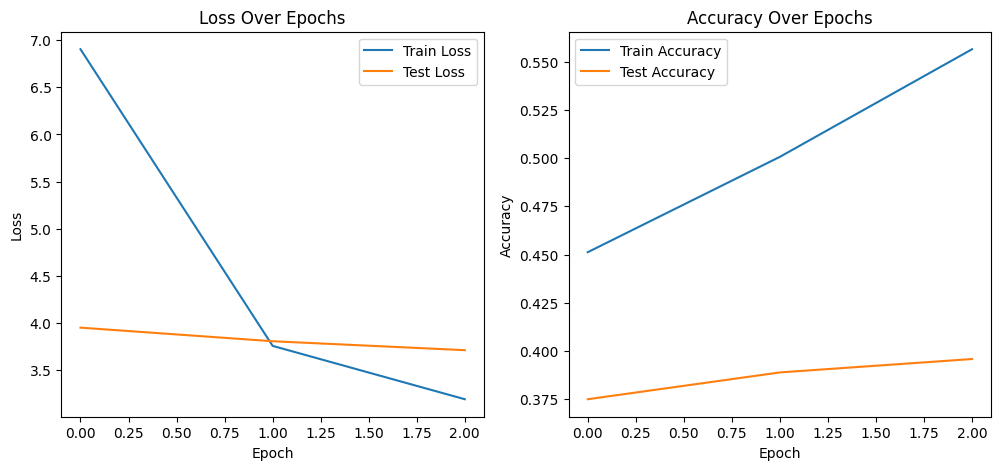

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [8]:
# calculate loss
average_loss = evaluate(model, test_loader)
print(f"Average Loss on Test Data: {average_loss}")
# calculate accuracy
accuracy = calculate_accuracy(model, test_loader)
print(f"Accuracy: {accuracy}")

Average Loss on Test Data: 3.714050769805908
Accuracy: 0.3958333333333333


In [8]:
# torch.save(model.state_dict(), 'model_weights_2.pth')
# torch.save(tokenizer, 'tokenizer_2.pth')